# Bayesian Inference for Standard Randomized Benchmarking

This notebook compare the frequentist least square fitter (LSF) with two bayesian models, respectively pooled and hierarchical, using a serial Monte Carlo (SMC) parameter estimation algorithm. 

The hierarchical model is inspired by equation 13 of the folowing reference:      
Ian Hincks, Joel J. Wallman, Chris Ferrie, Chris Granade and David G. Cory:
   [Bayesian Inference for Randomized Benchmarking Protocols](https:/arxiv.org/abs/1802.00401)

Options are given for data acquisition from simulation, from on line experiments on real hardware or from previous jobs stored on the ibm quantum experience data base.

NB: In order to ensure compatibility with the results of the SMC analysis, the values obtained by LSF are expressed in this notebook as $\mu$ ± $\sigma$.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit

import qiskit_experiments as qe
rb = qe.randomized_benchmarking
from scipy.optimize import curve_fit

# import the bayesian packages
import pymc3 as pm
import arviz as az

import bayesian_fitter as bf

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# choice of "simulation, "real", "retrieve"
option = "simulation"

In [4]:
# Determine the backend
if option == "simulation":
    from qiskit.test.mock import FakeAthens
    backend = FakeAthens()
    hardware = 'ibmq_athens' # hardware reference
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    device = provider.get_backend('ibmq_athens')
    backend = device
    hardware = device.name()  # hardware used  

## Running  RB

In [5]:
# RB design
q_list = [0,1]
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 5
seed = 1010 
num_qubits = len(q_list)
scale = (2 ** num_qubits - 1) / (2 ** num_qubits)
shots = 1024

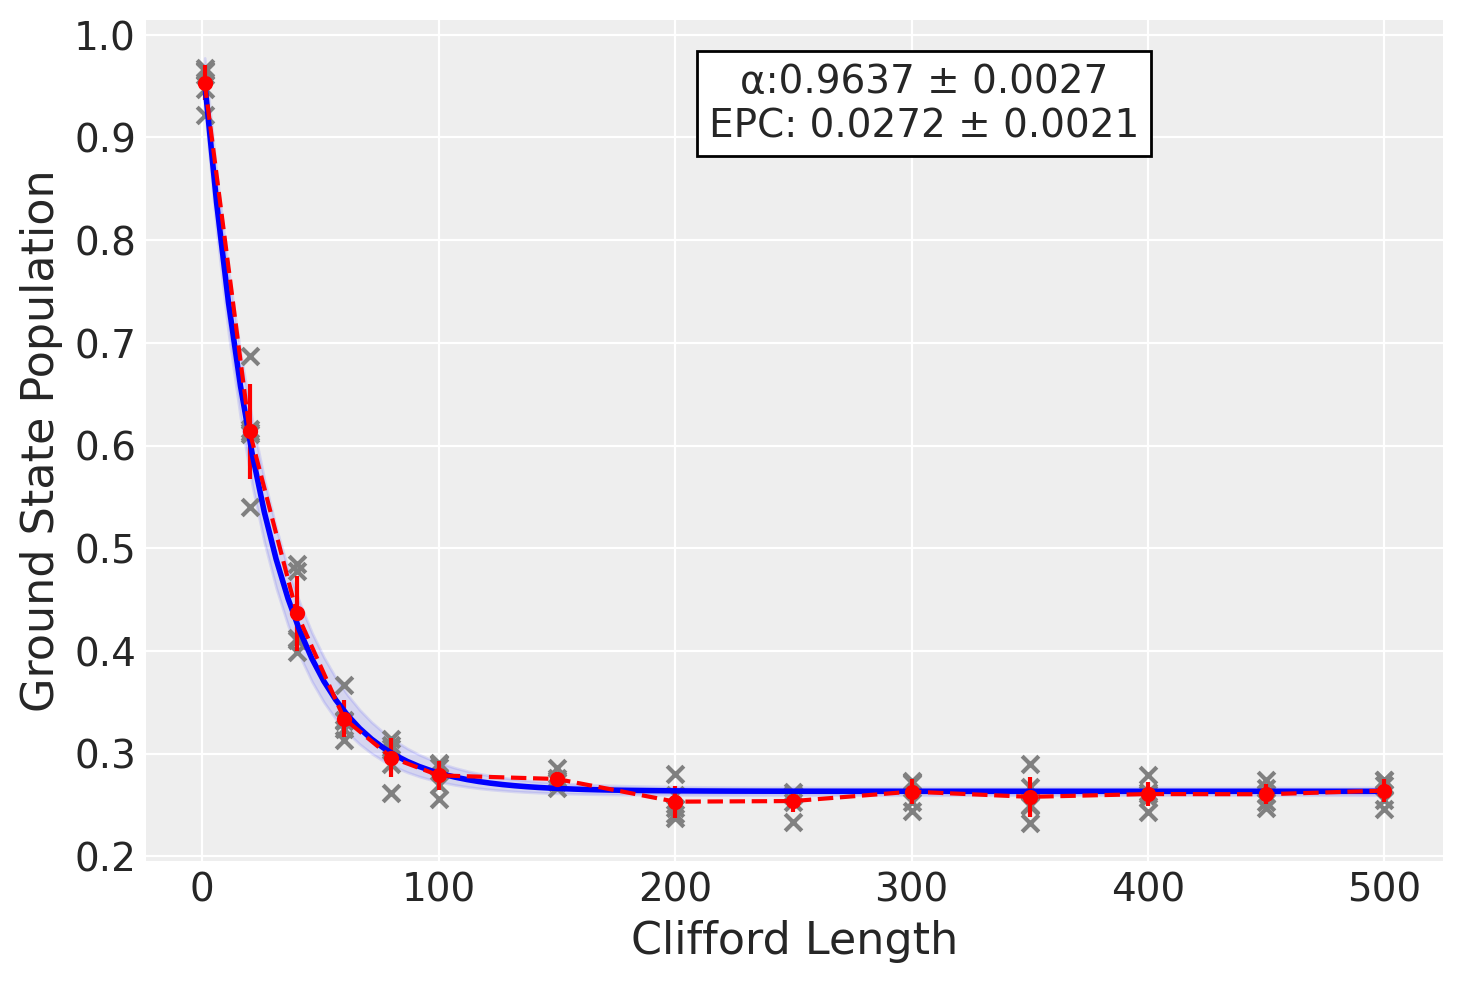

In [6]:
if option != "retrieve":
    exp = rb.RBExperiment(q_list, lengths, num_samples=num_samples, seed=seed)
    eda= exp.run(backend)

## Bayesian Models

In [7]:
# obtain EPC from alpha (used by plot_posterior)
def alpha_to_EPC(alpha):
        return scale*(1-alpha)   

In [8]:
# one or two qubits for retrieve and for the plots
list_bitstring = ['0', '00'] 

In [9]:
# obtain the current count values
Y_list = []

if option == "simulation":
    for i_sample in range(num_samples*len(lengths)):
        Y_list.append(eda.data[i_sample]['counts']\
                      [eda.data[i_sample]['metadata']['ylabel']])
        
else: # specify job (fresh job or run some time ago)
    job = backend.retrieve_job('6097aed0a4885edfb19508fa') # athens 01'

    for rbseed, result in enumerate(job.result().get_counts()):
            total_counts = 0
            for key,val in result.items():
                if  key in list_bitstring:
                    total_counts += val
            Y_list.append(total_counts)          
    
Y = np.array(Y_list).reshape(num_samples, len(lengths))

In [10]:
#get LSF EPC and priors
if option != "retrieve":
    popt = eda._analysis_results[0]['popt']
    pcov = eda._analysis_results[0]['pcov']

else: # manual entry (here for job ''6097aed0a4885edfb19508fa')
    popt = [0.7207075,  0.95899375, 0.2545933 ]
    pcov =  [[ 2.53455272e-04, -9.10001034e-06, -1.29839515e-05],
             [-9.10001034e-06,  9.55193998e-06, -7.07822420e-06],
             [-1.29839515e-05, -7.07822420e-06,  2.07452483e-05]]

alpha_ref=popt[1]     
mu_AB= [popt[0],popt[2]]
alpha_ref_err = np.sqrt(pcov[1][1])
EPC = scale*(1-alpha_ref)
EPC_err = scale*alpha_ref_err

cov_AB= [0.0001, 0.0001]
alpha_lower=0.8
alpha_upper=0.999                        
sigma_theta = .004

### Pooled model

In [11]:
pooled_model = bf.get_bayesian_model(model_type="pooled",
                                        Y=Y,shots=1024,m_gates=lengths,
                                        alpha_ref =  alpha_ref,
                                        mu_AB=mu_AB,cov_AB=cov_AB)

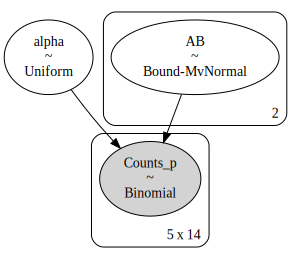

In [12]:
pm.model_to_graphviz(pooled_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 89 seconds.


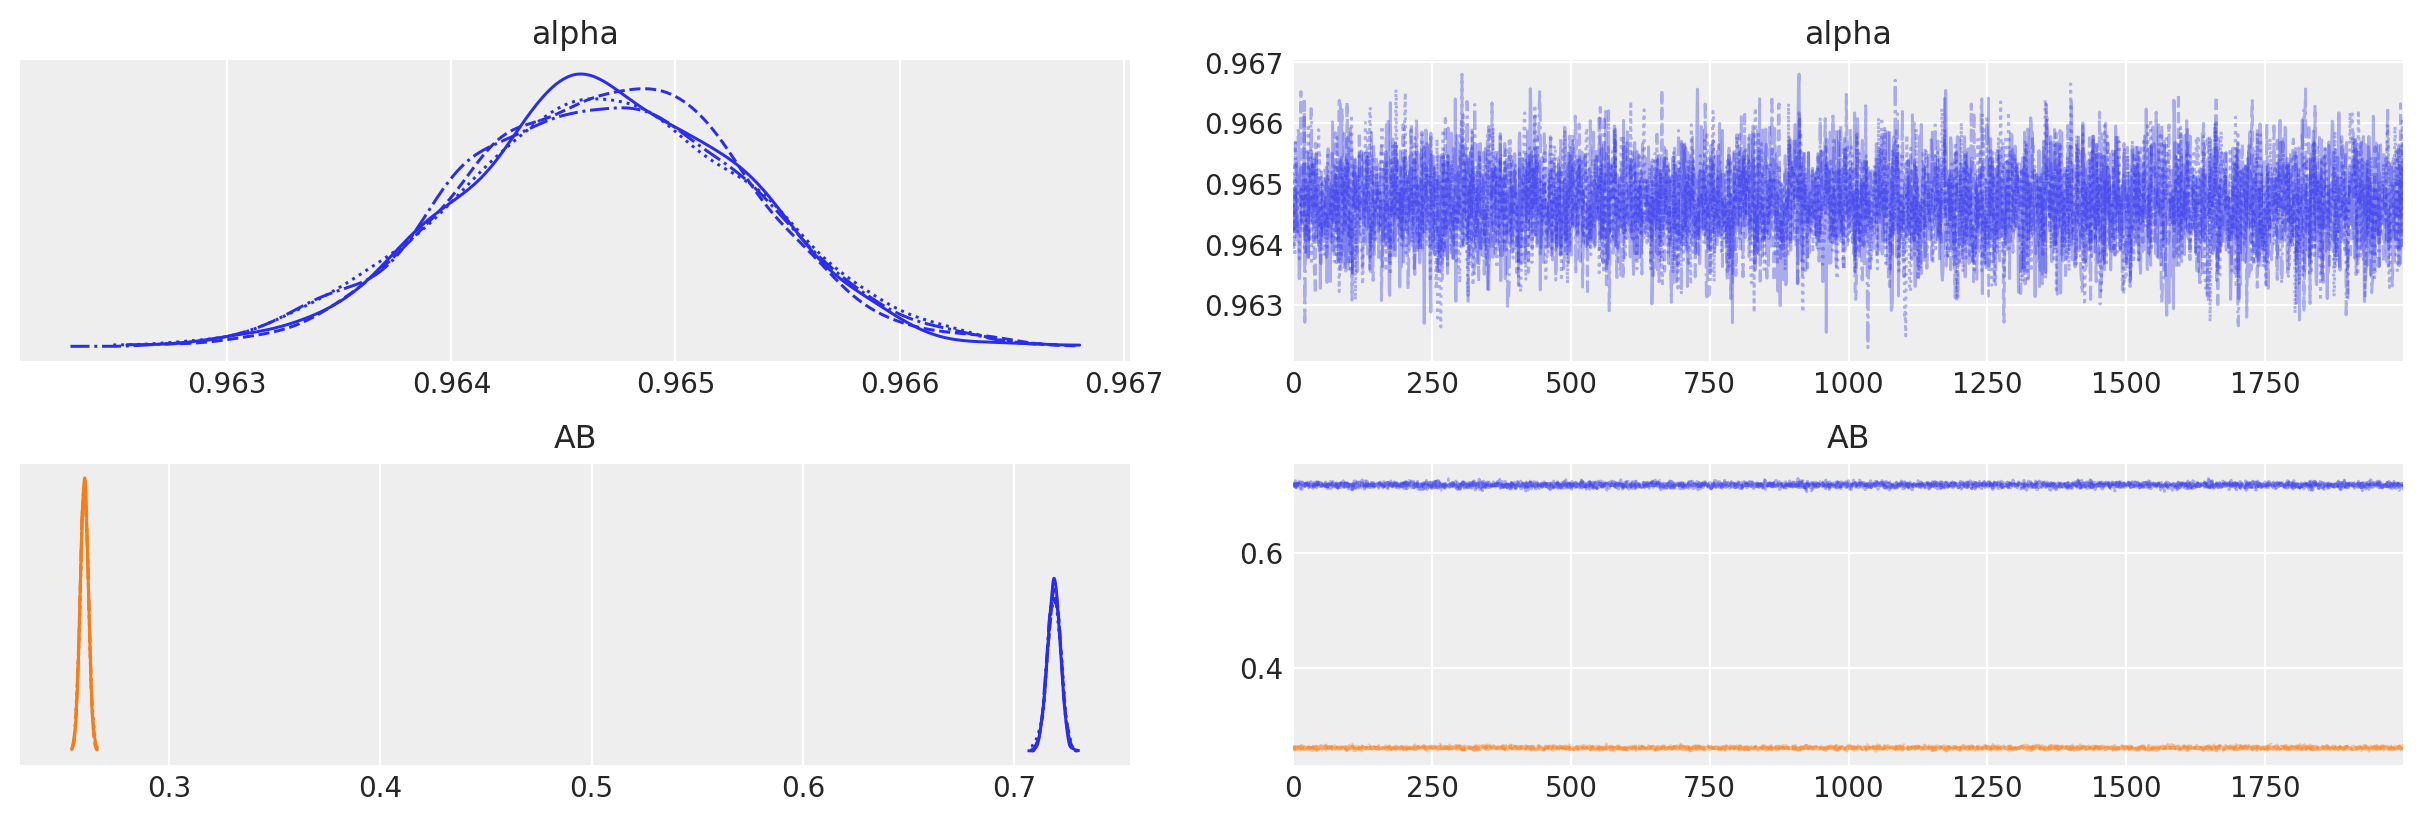

In [13]:
with pooled_model:   
    trace_p= pm.sample(draws = 2000, tune= 10000, target_accept=0.97,
                     return_inferencedata=True)    
    az.plot_trace(trace_p)

In [14]:
with pooled_model:
    azp_summary = az.summary(trace_p,  hdi_prob=.94, round_to=6, kind="all")
azp_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.964677,0.000643,0.963508,0.965910,0.000010,0.000007,4344.961135,4284.356141,1.001135
AB[0],0.718698,0.003207,0.712291,0.724466,0.000050,0.000035,4202.423106,4041.774848,1.001187
AB[1],0.260076,0.001922,0.256423,0.263676,0.000032,0.000023,3555.241669,3871.383129,1.000353


In [15]:
epc_p =scale*(1 - azp_summary['mean']['alpha'])
epc_p_err = scale* (azp_summary['sd']['alpha'])

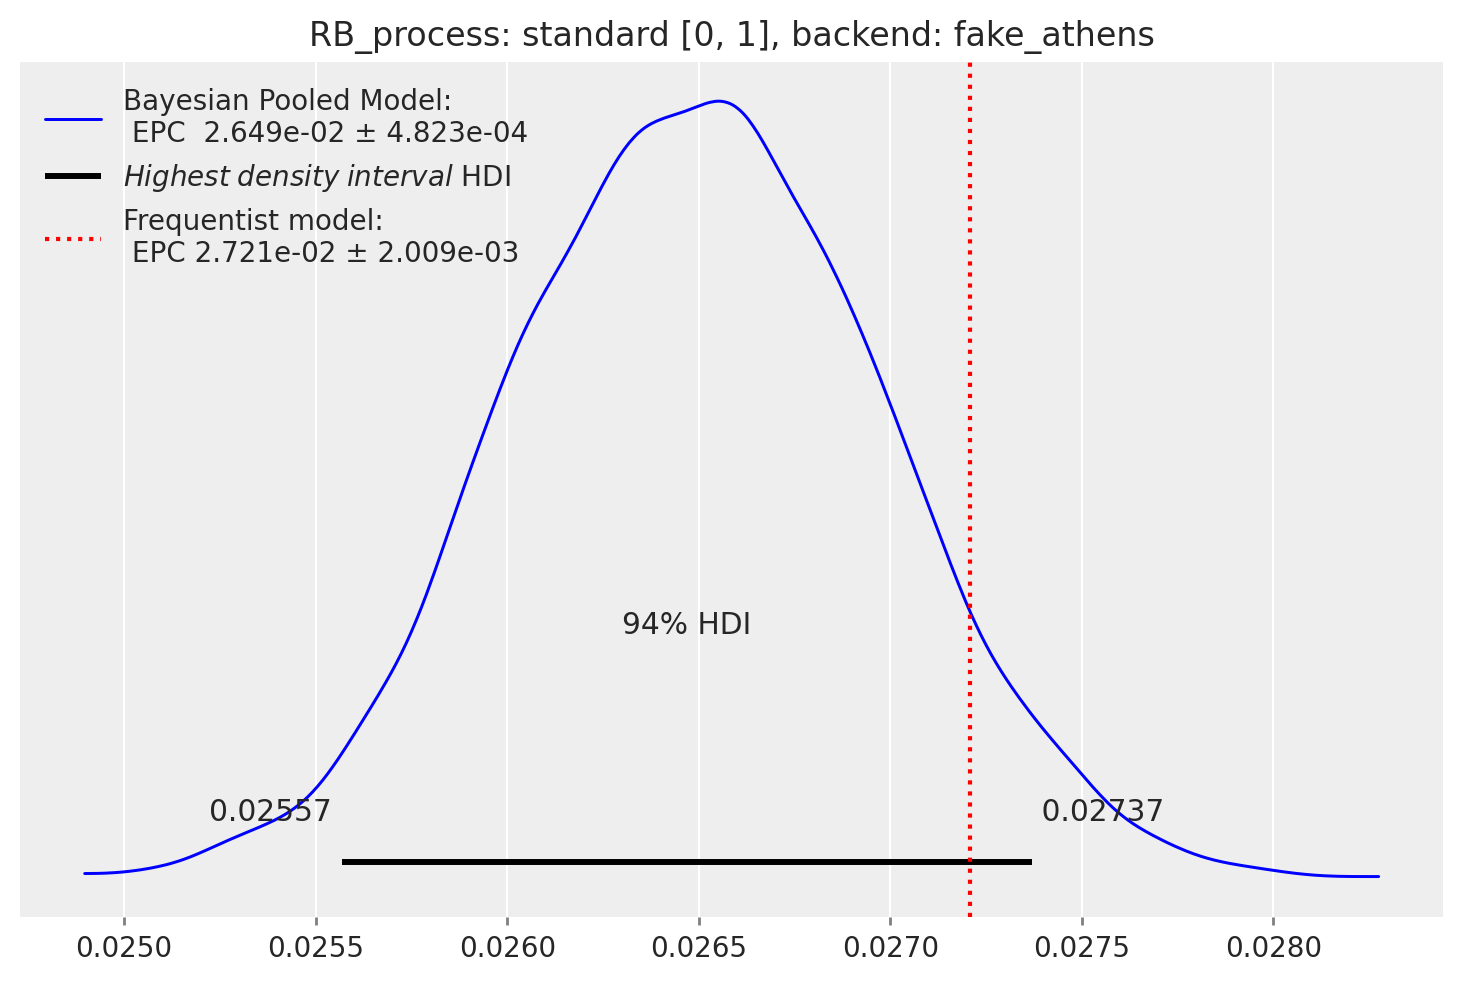

In [16]:
with pooled_model:
        ax = az.plot_posterior(trace_p,  var_names=['alpha'], round_to=4, point_estimate=None, 
                          transform =  alpha_to_EPC, textsize = 10.0, color='b')
        ax.set_title("RB_process: standard "+str(q_list)+", backend: "+backend.name(),
               fontsize=12)
        Bayes_legend ="Bayesian Pooled Model:\n EPC  {0:1.3e} ± {1:1.3e}".format(epc_p, epc_p_err)
        ax.axvline(x=EPC,color='r',ls=":")
        Fitter_legend ="Frequentist model:\n EPC {0:1.3e} ± {1:1.3e}".format(EPC, EPC_err) 
        ax.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                   Fitter_legend),fontsize=10 )                       

### Hierarchical model

In [17]:
hierarchical_model = bf.get_bayesian_model(model_type="hierarchical",
                                        Y=Y,shots=1024,m_gates=lengths,
                                        alpha_ref =  alpha_ref,
                                        mu_AB=mu_AB,cov_AB=cov_AB)

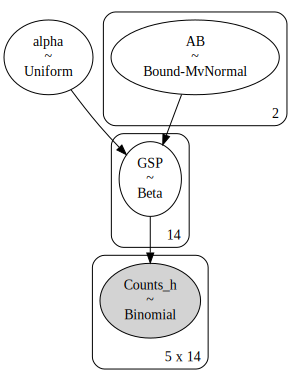

In [18]:
pm.model_to_graphviz(hierarchical_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GSP, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 161 seconds.


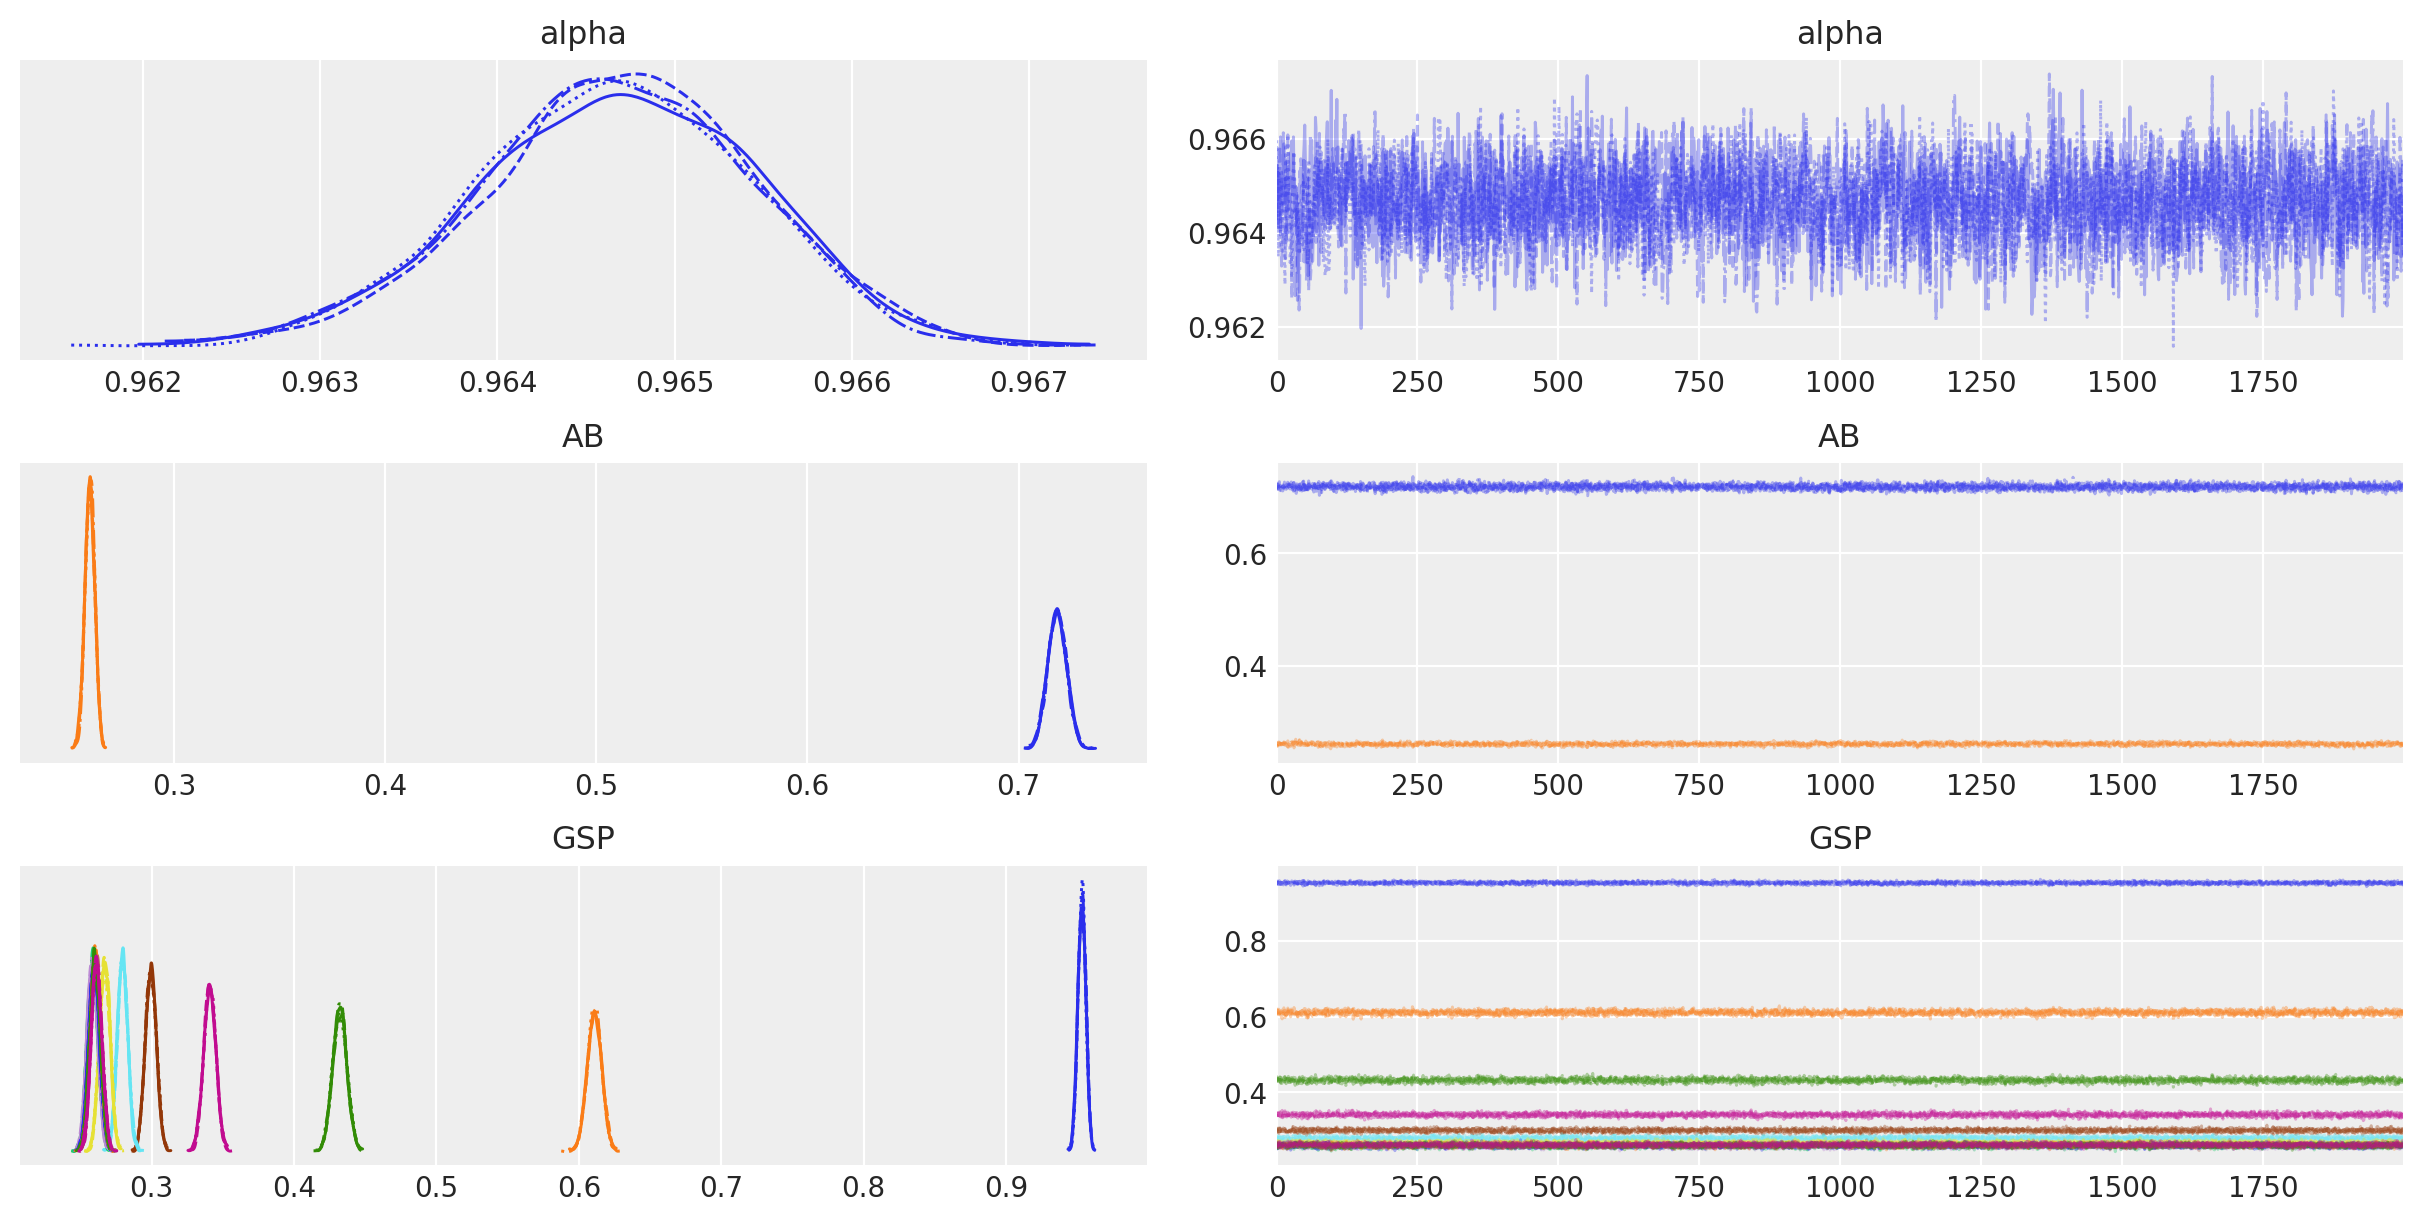

In [19]:
with hierarchical_model:   
    trace_h= pm.sample(draws = 2000, tune= 10000, target_accept=0.97,
                     return_inferencedata=True)    
    az.plot_trace(trace_h)

In [20]:
with hierarchical_model:
    azh_summary = az.summary(trace_h,  hdi_prob=.94, round_to=6,
                             kind="all", var_names=["~GSP"])
azh_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.964670,0.000774,0.963173,0.966063,0.000015,0.000011,2639.826896,4117.454836,1.001153
AB[0],0.718281,0.004430,0.709981,0.726473,0.000059,0.000042,5625.112780,6256.086142,1.001098
AB[1],0.260239,0.002298,0.255899,0.264555,0.000046,0.000033,2444.229877,4186.648786,1.001466


In [21]:
epc_h =scale*(1 - azh_summary['mean']['alpha'])
epc_h_err = scale* (azh_summary['sd']['alpha'])

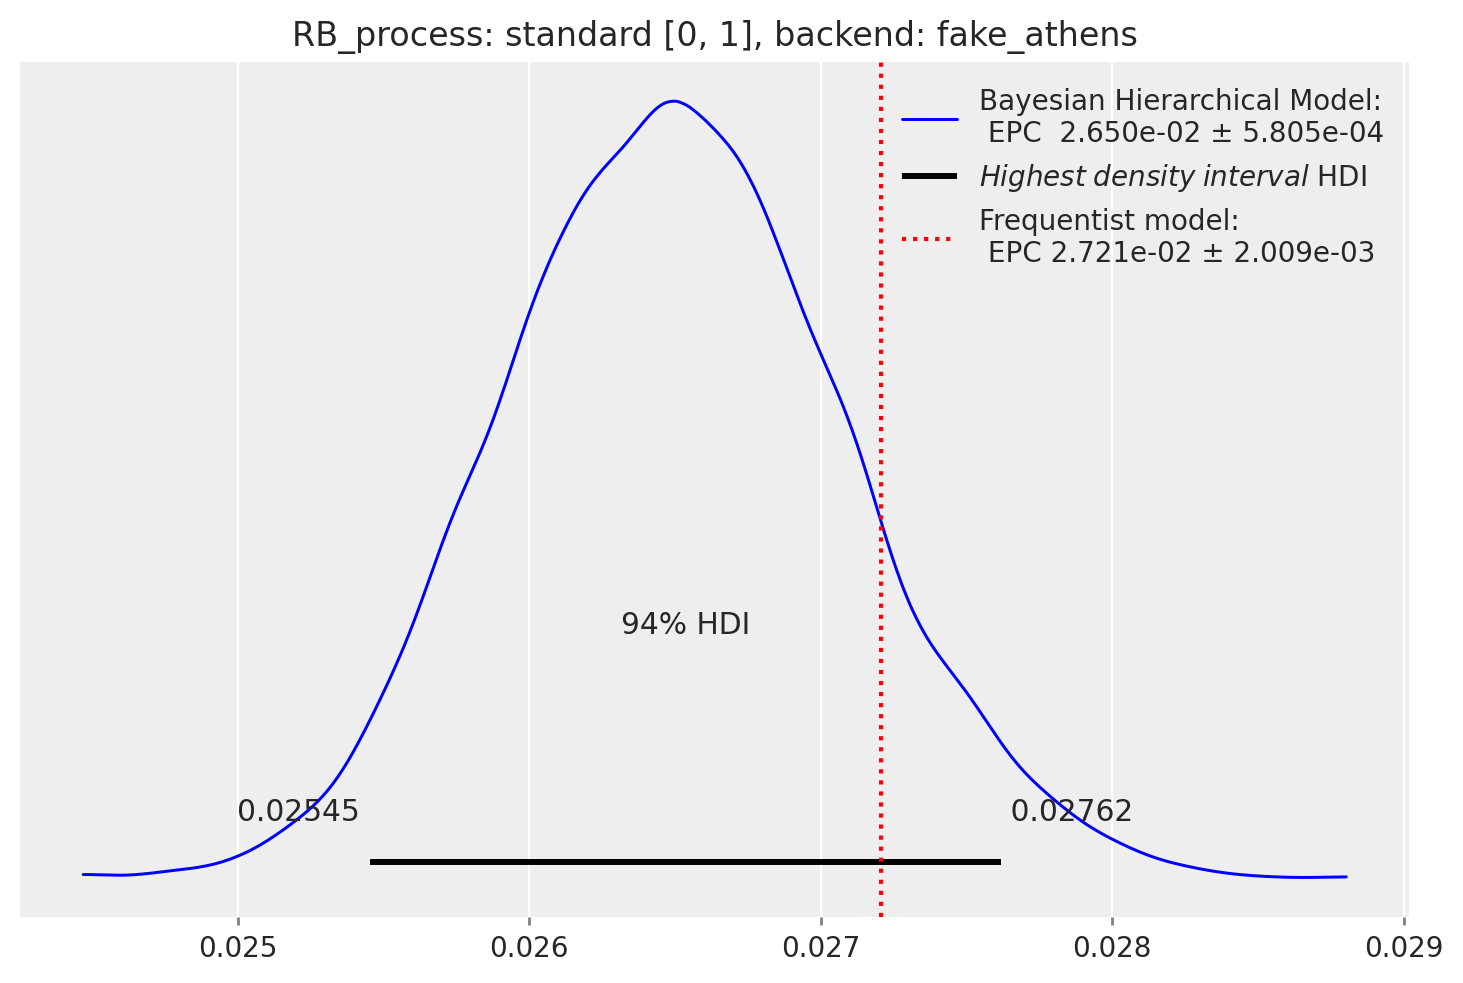

In [22]:
with hierarchical_model:
        ax = az.plot_posterior(trace_h,  var_names=['alpha'], round_to=4, point_estimate=None, 
                          transform =  alpha_to_EPC, textsize = 10.0, color='b')
        ax.set_title("RB_process: standard "+str(q_list)+", backend: "+backend.name(),
               fontsize=12)
        Bayes_legend ="Bayesian Hierarchical Model:\n EPC  {0:1.3e} ± {1:1.3e}".format(epc_h, epc_h_err)
        ax.axvline(x=EPC,color='r',ls=":")
        Fitter_legend ="Frequentist model:\n EPC {0:1.3e} ± {1:1.3e}".format(EPC, EPC_err) 
        ax.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                   Fitter_legend),fontsize=10 )                       

## Compare LSF and SMC models

In [23]:
# compare LSF and SMC
print("Model:  Frequentist            Bayesian")
print("           LSF           pooled      hierarchical")
print("EPC      {0:.5f}         {1:.5f}       {2:.5f}"
      .format(EPC, epc_p, epc_h))
print("ERROR   ± {0:.5f}       ± {1:.5f}     ± {2:.5f}"
      .format(EPC_err, epc_p_err, epc_h_err))

Model:  Frequentist            Bayesian
           LSF           pooled      hierarchical
EPC      0.02721         0.02649       0.02650
ERROR   ± 0.00201       ± 0.00048     ± 0.00058


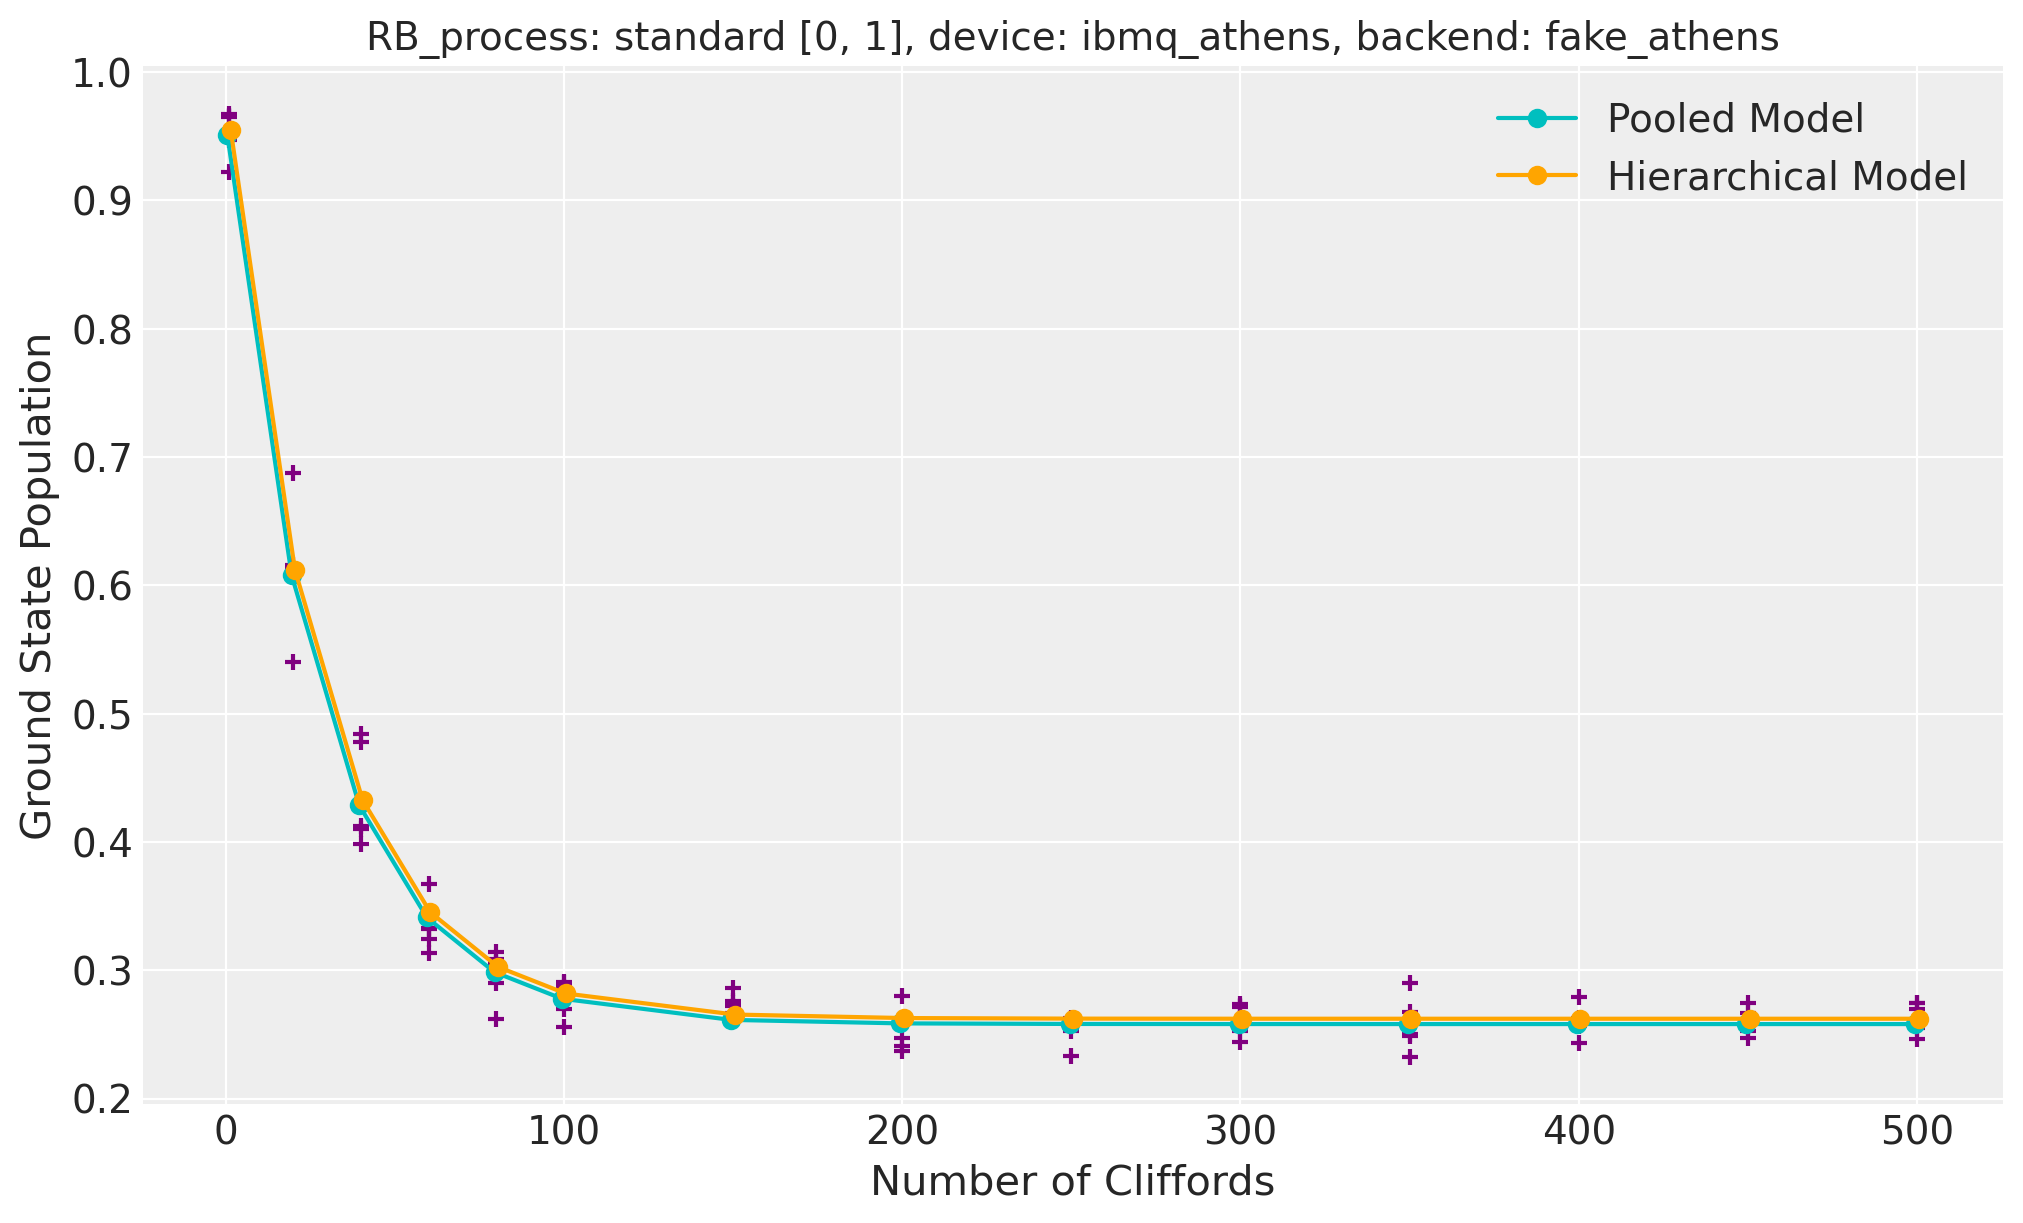

In [24]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

#fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

plt.set_ylabel("Ground State Population")
plt.set_xlabel("Number of Cliffords")

for i_seed in range(num_samples):
    plt.scatter(lengths, Y[i_seed,:]/1024, label = "data",
                marker="+",color="purple")
plt.plot(np.array(lengths)-0.5,azp_summary['mean']['AB[0]']\
         *azp_summary['mean']['alpha']**lengths+\
          azp_summary['mean']['AB[1]']-0.002,'o-',color="c")
plt.plot(np.array(lengths)+0.5,azh_summary['mean']['AB[0]']\
         *azh_summary['mean']['alpha']**\
          lengths+azh_summary['mean']['AB[1]']+0.002,'o-',color="orange")

plt.legend(("Pooled Model",
             "Hierarchical Model"))

plt.set_title("RB_process: standard "+str(q_list)+\
              ", device: "+hardware+', backend: '+backend.name(),
              fontsize=14);

## Ranking pooled and hierarchical models
ref: https://docs.pymc.io/notebooks/model_comparison.html

In [25]:
# Leave-one-out Cross-validation (LOO) comparison
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

C:\Users\decpi\Anaconda3\envs\QK25\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\decpi\Anaconda3\envs\QK25\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\decpi\Anaconda3\envs\QK25\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal pos

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pooled,0,-342.583702,12.886881,0.000000,1.0,21.991787,0.000000,True,log
hierarchical,1,-345.210186,19.127148,2.626483,0.0,22.511839,1.264725,True,log


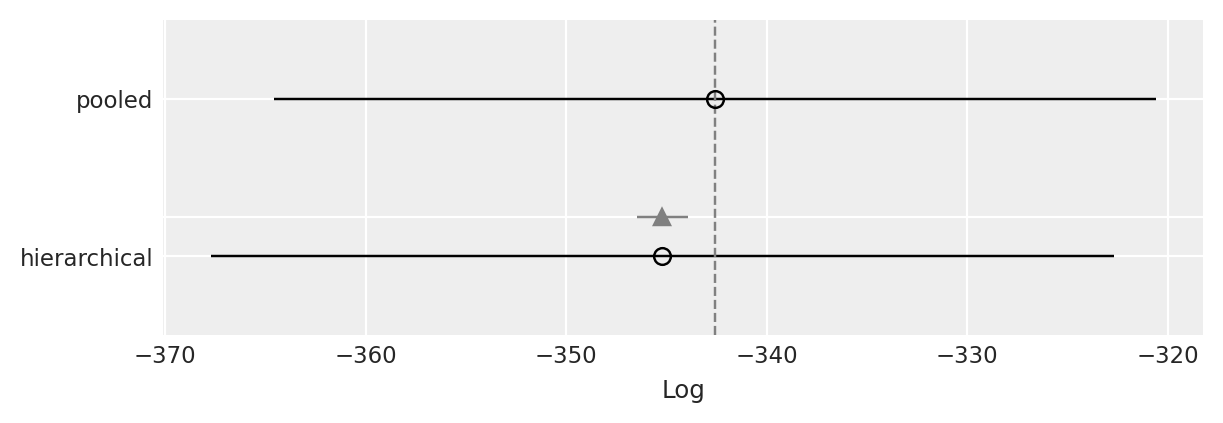

In [26]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table